### CT Statewide House Sales Transactions
This notebook is exploring the data from https://data.ct.gov/Housing-and-Development/Real-Estate-Sales-2001-2016/5mzw-sjtu?category=Housing-and-Development , which lists CT statewide sales transactions on individual properties from 2001-2016.
* Note: this link includs a PDF that explains each of the NonUseCodes.

My GitHub repository: https://github.com/jamiekasulis/ct_real_estate_sales, where you can view
* The raw data file
* The notebook I used to clean that file
* The clean data files that I analyze here

### Potential Inquiries
* See where properties with multiple transactions gained and lost value --> (How many houses, how much value, by town, over different periods of time)
* Foreclosures-- where and when have there been a lot?
* Building of new developments? (Might be shown by selling many houses in a short period of time on a new road)
* Signs of house flipping, i.e. a purchase and a sale for significantly more within a short period
* Has recovery been different for different segments of the market (different price-range houses)?
* Are there observable effects of the crumbling fundations in the northeastern part of CT?

### Calculations
* Adjust sales prices for inflation/season -- there is a Python package for seasonal adjustment
* Take a close look at the assessment column
* Each town's assessment rate, or look at a hosue's sale ratio relative to its town only
* Distribution of house prices in given towns, or on given streets
* Town-by-town medians, ranges

### Themes
* Recovery

In [72]:
import pandas as pd
import matplotlib
%matplotlib inline

#### Update MAX_YEAR when new data comes out.

In [2]:
MIN_YEAR = 2001
MAX_YEAR = 2016 # update this when new data comes out

In [3]:
def combine_data_into_master_df():
    """
    Returns a DataFrame which combines all of the clean CSVs for each year.
    """
    # Combine the year-by-year clean csvs, which are located at 'data/clean_data_20xx_listings.csv'
    df = pd.read_csv('data/clean_data_' + str(MIN_YEAR) + '_listings.csv')
    for year in range(MIN_YEAR+1, MAX_YEAR+1):
        df = df.append(pd.read_csv('data/clean_data_' + str(year) + '_listings.csv'))

    # Now remove the index column
    #df = df.drop('Unnamed: 0', 1)
    return df

In [4]:
df = combine_data_into_master_df()
df.head()

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
0,684,10173,2001,04/17/2002 12:00:00 AM,Ansonia,1-3 EAGLE STREET,63630,116000.0,54.853448,Residential,Two Family,0,NaN
1,694,10005,2001,10/04/2001 12:00:00 AM,Ansonia,1 CRESTWOOD ROAD,76370,160000.0,47.731250,Residential,Single Family,0,NaN
2,697,10253,2001,06/18/2002 12:00:00 AM,Ansonia,1 DAVIES CT,97720,180000.0,54.288889,Residential,Single Family,0,NaN
3,698,10094,2001,01/17/2002 12:00:00 AM,Ansonia,1 DOREL TER,110600,259900.0,42.554829,Residential,Single Family,0,NaN
4,710,10100,2001,01/30/2002 12:00:00 AM,Ansonia,1 JAMES STREET,63210,132000.0,47.886364,Residential,Single Family,0,NaN


In [5]:
df.tail()

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
49768,813238,160015,2016,10/25/2016 12:00:00 AM,Woodbury,UPPER GRASSY HILL ROAD(66-4),3500,115000.0,0.030435,Vacant Land,NaN,28,PURCHASED LAND IN OPEN SPACE FROM UNCLE
49769,813243,160085,2016,02/17/2017 12:00:00 AM,Woodbury,WASHINGTON ROAD,1540,77000.0,0.020000,Vacant Land,NaN,14,SALE WITH ID: 143600
49770,813244,160153,2016,06/20/2017 12:00:00 AM,Woodbury,WASHINGTON ROAD,68230,72500.0,0.941103,Vacant Land,NaN,-1,UNIQUE ID: 174200
49771,813245,160112,2016,04/24/2017 12:00:00 AM,Woodbury,WEEKEEPEEMEE ROAD,186430,150000.0,1.242867,Vacant Land,NaN,10,ID 208400
49772,813263,160047,2016,12/30/2016 12:00:00 AM,Woodbury,WHITE DEER ROCKS ROAD (8-12D),5090,50000.0,0.101800,Vacant Land,NaN,28,OPEN SPACE


In [6]:
# Make sure the IDs match the right rows from the original raw file
df.sort_values('ID') # Looks good

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
0,1,14046,2014,09/29/2015 12:00:00 AM,Andover,US ROUTE 6 M 33 B 36 L 22,10720,75000.0,0.142933,Vacant Land,NaN,-1,NaN
0,2,900035,2009,07/20/2010 12:00:00 AM,Andover,1 DOGWOOD DRIVE,55600,99000.0,0.561616,Vacant Land,NaN,-1,NaN
1,3,14011,2014,01/14/2015 12:00:00 AM,Andover,1 JUROVATY LANE,153100,190000.0,0.805789,Residential,Single Family,-1,NaN
0,4,80009,2008,01/21/2009 12:00:00 AM,Andover,1 ROSE LANE,116600,138900.0,0.839453,Residential,Single Family,-1,NaN
0,5,15006,2015,11/30/2015 12:00:00 AM,Andover,1 ROSE LANE,102900,50000.0,2.058000,Residential,Single Family,14,PROPERTY WAS OWNED BY THE BANK
0,6,20030,2002,04/24/2003 12:00:00 AM,Andover,10 BAUSOLA ROAD,91800,189900.0,48.341232,Residential,Single Family,0,NaN
1,7,20030,2002,04/24/2003 12:00:00 AM,Andover,10 BAUSOLA ROAD,91800,189900.0,48.340000,Residential,Single Family,0,NaN
0,8,30047,2003,04/19/2004 12:00:00 AM,Andover,10 CHESTER BRKS LANE,56600,80000.0,70.750000,Vacant Land,NaN,0,NaN
0,9,40003,2004,10/18/2004 12:00:00 AM,Andover,10 CHESTER BRKS LANE,194100,446639.0,43.457916,Residential,Single Family,7,NaN
0,10,70005,2007,11/19/2007 12:00:00 AM,Andover,10 CHESTER BROOKS LANE,313400,425000.0,0.737412,Residential,Single Family,-1,NaN


### Notes on the data frames
* Use DataFrame 'df' if you want to look at ALL of the data
* Use 'use_df' if you want to just look at the rows that don't have NonUseCodes. You should use use_df if you are calculating any statistics.
* Use 'res_df' if you want to look at RESIDENTIAL properties (but not condos or apartments) that don't have NonUseCodes. Best way to observe the real estate market in general.

In [7]:
def get_residential(df):
    """
    Returns just the residential properties.
    """
    return df[df['PropertyType'] == 'Residential']

def get_commercial(df):
    """
    Returns just the commercial properties.
    """
    return df[df['PropertyType'] == 'Commercial']

In [48]:
use_df = df[df['NonUseCode'] < 1]
res_df = get_residential(use_df)

In [49]:
# Check
use_df[use_df['NonUseCode'] != -1]
res_df[res_df['PropertyType'] != 'Residential']

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks


### Foreclosures-- where and when have there been a lot?
Note: In order for this analysis to be truthfully valuable, you should do some kind of adjustment. This might be very complicated. (Adjusting by population fails to weigh folks living in apartments, for example.)

In [10]:
# How many foreclosures on properties 2001-2016?
foreclosures = df[df['NonUseCode'] == 14]
print("Number of properties that have been foreclosed on: %d" %len(foreclosures['Address'].unique()))

Number of properties that have been foreclosed on: 35797


#### Make a function to return a DataFrame that ranks towns by most foreclosures.

In [11]:
def count_foreclosures_by_town(df, town, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a subset of df of foreclosed properties from town.
    Is a helper function for make_foreclosures_by_town_dict()
    """
    # Make sure proper arguments passed
    if property_type not in ['Residential', 'Commercial', 'All']:
        raise Exception("Not a valid property_type.")
        return
    if years[0] < MIN_YEAR or years[1] > MAX_YEAR:
        raise Exception("Not a valid year range")
        return
    
    else:
        # Convert year range to a list of all years in that range
        years = list(range(years[0], years[1]+1))
    
    subset = df[(df['Town'] == town) & (df['ListYear'].isin(years)) & (df['NonUseCode'] == 14)]
    return subset

In [12]:
def make_foreclosures_by_town_dict(df, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a dictionary with keys = town name and value = number of foreclosures.
    This function feeds make_rankings_df_from_dict.
    """
    foreclosure_ranks_by_town = {}
    for town in df['Town'].unique():
        if town not in foreclosure_ranks_by_town.keys():
            foreclosure_ranks_by_town[town] = len(count_foreclosures_by_town(df, town, years, property_type))
    return foreclosure_ranks_by_town

In [13]:
def make_rankings_df_from_dict(dictionary, value_name):
    """
    Makes a dataframe out of a dictionary. First column name is 'Town' and second is value_name.
    dictionary should be produced by an explicit call to make_foreclosures_by_town_dict.
    """
    df = pd.DataFrame.from_dict(data=dictionary, orient='index') # make initial df
    df['Town'] = df.index # pull index out into its own column
    df.columns = [value_name, 'Town'] # Set column names
    df = df[['Town', value_name]] # Reorder the columns
    
    df = df.sort_values(value_name, ascending=False, ) # Sort
    df = df.reset_index(drop=True)
    
    return df

In [14]:
def rank_towns_by_foreclosure_count(df, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a dataframe of each town and the number of foreclosures they experienced in the range 'years'.
    Descending order. Index+1 can serve as the rank.
    The only function you should have to explicitly call to do this. All helper functions are called within.
    """
    return make_rankings_df_from_dict(make_foreclosures_by_town_dict(df), 'Foreclosures')

In [15]:
# Dataframe of foreclosure rankings by town, all years (MIN_YEAR to MAX_YEAR)
fc_rankings_town_all_years = rank_towns_by_foreclosure_count(df)

In [16]:
fc_rankings_town_all_years.head()

,Town,Foreclosures
0,Bridgeport,3407
1,Waterbury,3173
2,New Britain,1600
3,New Haven,1257
4,Torrington,1190


### Calculate town-by-town statistics
* Median assessed value
* Median sale amount
* Median sales ratio

### Dataframes:
* town_df for all residential properties without NonUseCodes in time range MINYEAR - MAXYEAR

In [17]:
# Make a dataframe with each town. We will store summary statistics in this dataframe.
town_df = pd.DataFrame(columns=['Town', 'MedianAssessedValue', 'MedianSaleAmount', 'MedianSalesRatio',
                               'MinAssessedValue', 'MaxAssessedValue', 'MinSaleAmount', 'MaxSaleAmount',
                               'MinSalesRatio', 'MaxSalesRatio'])
town_df['Town'] = df['Town'].unique()

In [18]:
town_df.head()

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ashford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Avon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Barkhamsted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Berlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
def calculate_median_for_town(source_df, town, column, residential=True):
    """
    Calculates the median value of 'column' for a given town from df.
    NOTE: This is the median assessed value for SOLD properties. Will be
    different from the median assessed value for ALL properties.
    
    source_df should omit properties with a NonUseCode.
    """
    town_df = source_df[source_df['Town'] == town]
    
    if residential==True:
        town_df = get_residential(town_df)
    
    return town_df[column].median()

In [20]:
def calculate_medians_for_all_towns(town_df, source_df, column, residential=True):
    """
    Calculates the median value of 'column' for ALL unique towns in df.
    Returns this information as a DataFrame
    """
    median_column_name = 'Median' + column
    new_town_df = town_df.copy()
    for index in new_town_df.index:
        town = new_town_df.loc[index, 'Town']
        new_town_df.loc[index, median_column_name] = calculate_median_for_town(source_df, town, column, residential)
    
    return new_town_df

In [21]:
town_df = calculate_medians_for_all_towns(town_df, use_df, 'AssessedValue').head()

In [22]:
town_df.head()

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,128900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ashford,137745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Avon,282610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Barkhamsted,159900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Berlin,172400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
town_df = calculate_medians_for_all_towns(town_df, use_df, 'SaleAmount').head()
town_df = calculate_medians_for_all_towns(town_df, use_df, 'SalesRatio').head()

In [24]:
town_df.head()

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,128900,195750,0.691169,NaN,NaN,NaN,NaN,NaN,NaN
1,Ashford,137745,213000,0.700784,NaN,NaN,NaN,NaN,NaN,NaN
2,Avon,282610,412000,0.699646,NaN,NaN,NaN,NaN,NaN,NaN
3,Barkhamsted,159900,250000,0.660984,NaN,NaN,NaN,NaN,NaN,NaN
4,Berlin,172400,258000,0.683516,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Let's check to make sure the numbers match.
berlin_sales = res_df[(res_df['Town'] == 'Berlin') & (res_df['PropertyType'] == 'Residential')]
print(berlin_sales['AssessedValue'].median())
print(berlin_sales['SaleAmount'].median())
print(berlin_sales['SalesRatio'].median())

172400.0
258000.0
0.6835164835164841


In [26]:
avon_sales = res_df[(res_df['Town'] == 'Avon') & (res_df['PropertyType'] == 'Residential')]
print(avon_sales['AssessedValue'].median())
print(avon_sales['SaleAmount'].median())
print(avon_sales['SalesRatio'].median())

282610.0
412000.0
0.699645645645646


### Calculate SalesRatio
If my calculation of it is the same, then they use their SaleAmount to calculate it. Otherwise, they are using a market estimation.

*Data page defines SalesRatio as 'Ratio of the sale price to the assessed value.' I want to know if 'sales price' refers to SalesAmount or not.*

In [ ]:
res_df[['Address', 'AssessedValue', 'SaleAmount', 'SalesRatio']].head(5)

I'll calculate SalesRatio myself and compare them side-by-side.

In [ ]:
res_df_testing = res_df.copy()
res_df_testing['MySalesRatio'] = res_df_testing['AssessedValue'] / res_df_testing['SaleAmount']
res_df_testing[['SalesRatio', 'MySalesRatio']].head()

For some reason, the first row has a SalesRatio of 0 when it doesn't seem like it should be. Could be an error when the data was entered.

### Calculate minimum and maximum sale amounts for each town

In [27]:
def get_town_min(source_df, town_df, town, column):
    """
    Finds the row with the minimum value of column for a given town in source_df.
    Saves this to town_df (as a separate copy).
    
    source_df should be residential properties w/o NonUseCodes if you are using res_df.
    """
    just_this_town = source_df[source_df['Town'] == town] # get the data for just this town
    
    min_val = just_this_town[column] # a list of values to find the minimum from
    min_val = min_val.min() # Grab the minimum column value
    min_row = just_this_town[just_this_town[column] == min_val] # Grab the row
    return min_row

In [28]:
get_town_min(res_df, town_df, 'Berlin', 'SaleAmount')

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
1076,14948,140059,2014,12/04/2014 12:00:00 AM,Berlin,23 JEFFREY LANE,220400,4000.0,55.1,Residential,Single Family,-1,NaN


In [29]:
def get_town_max(source_df, town_df, town, column):
    """
    Finds the row with the maximum value of column for a given town in source_df.
    Saves this to town_df (as a separate copy).
    
    source_df should be residential properties w/o NonUseCodes if you are using res_df.
    """
    just_this_town = source_df[source_df['Town'] == town] # get the data for just this town
    
    town_df = just_this_town[column] # a list of values to find the minimum from
    max_val = town_df.max() # Grab the minimum column value
    max_row = just_this_town[just_this_town[column] == max_val] # Grab the row
    return max_row

In [30]:
get_town_max(res_df, town_df, 'Berlin', 'SaleAmount')

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
635,16666,130084,2013,12/31/2013 12:00:00 AM,Berlin,66 QUINCY TRAIL,542900,700000.0,0.776,Residential,Single Family,-1,NaN


In [31]:
def calculate_town_mins_and_maxes(source_df, town_df, column):
    """
    Will use the data from source_df to calculate mins and maxes for column for every town.
    """
    new_town_df = town_df.copy()
    
    # Calculate min and max for each town
    for index in town_df.index:
        max_val = get_town_max(source_df, town_df, town_df.loc[index, 'Town'], column)[column].iloc[0]
        min_val = get_town_min(source_df, town_df, town_df.loc[index, 'Town'], column)[column].iloc[0]
    
        # Add to new_town_df
        min_column_name = 'Min' + column
        max_column_name = 'Max' + column
        new_town_df.loc[index, min_column_name] = min_val
        new_town_df.loc[index, max_column_name] = max_val
    
    return new_town_df

In [32]:
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'SaleAmount')
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'SalesRatio')
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'AssessedValue')
town_df.head(5)

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,128900,195750,0.691169,29800,312600,20100,645000,0.271374,5.81592
1,Ashford,137745,213000,0.700784,46300,334300,40000,495000,0.256527,2.17623
2,Avon,282610,412000,0.699646,50820,2896370,7500,5e+06,0.180948,23.8467
3,Barkhamsted,159900,250000,0.660984,62260,440750,16000,700000,0.408118,5.56438
4,Berlin,172400,258000,0.683516,0,1571000,4000,700000,0,55.1


In [33]:
get_town_max(res_df, town_df, 'Ansonia', 'SalesRatio')

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
280,3547,14267,2014,06/05/2015 12:00:00 AM,Ansonia,70 NORTH PROSPECT STREETREET,116900,20100.0,5.81592,Residential,Single Family,-1,NaN


In [34]:
get_town_min(res_df, town_df, 'Ansonia', 'SalesRatio')

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
227,3612,60015,2006,10/16/2006 12:00:00 AM,Ansonia,75 GROVE STREET,71100,262000.0,0.271374,Residential,Single Family,-1,addl remarks


In [35]:
get_town_max(res_df, town_df, 'Ansonia', 'AssessedValue')

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
133,2166,13012,2013,04/28/2014 12:00:00 AM,Ansonia,26 CRESCENT STREETREET,312600,645000.0,0.485,Residential,Four Family,-1,NaN


In [36]:
get_town_min(res_df, town_df, 'Ansonia', 'AssessedValue')

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
145,2654,60108,2006,03/27/2007 12:00:00 AM,Ansonia,35 WOODBRIDGE AVE,29800,74000.0,0.402703,Residential,Single Family,-1,addl remarks


In [37]:
ansonia = res_df[res_df['Town'] == 'Ansonia']
ansonia.sort_values('SalesRatio', ascending=True)
ansonia.sort_values('SalesRatio', ascending=False)
ansonia.sort_values('AssessedValue', ascending=True)
ansonia.sort_values('AssessedValue', ascending=False)
# Looks good.

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
133,2166,13012,2013,04/28/2014 12:00:00 AM,Ansonia,26 CRESCENT STREETREET,312600,645000.0,0.485000,Residential,Four Family,-1,NaN
112,2239,90019,2009,10/30/2009 12:00:00 AM,Ansonia,27 LAROVERA TERR,292200,410000.0,0.712683,Residential,Single Family,-1,NaN
117,2285,90082,2009,04/01/2010 12:00:00 AM,Ansonia,28 HOINSKI WAY,291400,376000.0,0.775000,Residential,Single Family,-1,NaN
49,762,90033,2009,11/16/2009 12:00:00 AM,Ansonia,10 CLIFFORD DRIVE,269800,365000.0,0.739178,Residential,Single Family,-1,NaN
68,1798,1172,2011,04/10/2012 12:00:00 AM,Ansonia,20 LAROVERA TERR,269000,307500.0,0.874797,Residential,Single Family,-1,NaN
130,2741,80014,2008,10/31/2008 12:00:00 AM,Ansonia,38 CONDON DRIVE,264300,380000.0,0.695526,Residential,Single Family,-1,NaN
156,3681,1105,2011,11/09/2011 12:00:00 AM,Ansonia,8 HOINSKI WAY,264200,310000.0,0.852258,Residential,Single Family,-1,NaN
133,2891,800312,2008,05/01/2009 12:00:00 AM,Ansonia,41 LAROVERA TERR,259900,360000.0,0.721944,Residential,Single Family,-1,NaN
73,1864,1195,2011,06/01/2012 12:00:00 AM,Ansonia,21 GRANITE TERR,252200,308000.0,0.818831,Residential,Single Family,-1,NaN
315,3909,15033,2015,11/16/2015 12:00:00 AM,Ansonia,95 BENZ STREETREET,251500,320000.0,0.785937,Residential,Single Family,-1,NaN


In [38]:
town_df

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,128900,195750,0.691169,29800,312600,20100,645000,0.271374,5.81592
1,Ashford,137745,213000,0.700784,46300,334300,40000,495000,0.256527,2.17623
2,Avon,282610,412000,0.699646,50820,2896370,7500,5e+06,0.180948,23.8467
3,Barkhamsted,159900,250000,0.660984,62260,440750,16000,700000,0.408118,5.56438
4,Berlin,172400,258000,0.683516,0,1571000,4000,700000,0,55.1


### These medians, mins, and maxes use data from all of the years.
Should I also be able to select just a particular year...?

### Time series
I want to be able to...
* Make the time series for a town's SaleAmount, MIN_YEAR to MAX_YEAR

In [63]:
def get_years_median(town, column, year, source_df=res_df):
    """
    Returns the median value of column for town from year, using data from source_df, as a list.
    """
    # Get the rows for this town in the given year
    just_this_town = source_df[source_df['Town'] == town]
    town_by_year = just_this_town[just_this_town['ListYear'] == year]

    # Calculate and return the median
    median = town_by_year[column].median()
    if median == 'nan':
        return -1
    else:
        return median

In [64]:
get_years_median('Berlin', 'SaleAmount', 2001)

195000.0

In [82]:
def median_timeseries(town, column, source_df=res_df, startyear=MIN_YEAR, endyear=MAX_YEAR):
    """
    Returns a time series for a particular town and column, from start year to endyear.
    Values are the median of column.
    Grabs the data from source_df.
    """
    # Make the DataFrame's attributes
    index = list(range(startyear, endyear+1))
    columns = [column]
    
    # Generate a list of medians using helper function
    list_of_medians = []
    for year in index:
        list_of_medians.append(get_years_median(town, column, year))
        
    return pd.DataFrame(data=list_of_medians, index=index, columns=columns)

In [93]:
median_timeseries('Berlin', 'SaleAmount')

,SaleAmount
2001,195000.0
2002,NaN
2003,245000.0
2004,260000.0
2005,271250.0
2006,278450.0
2007,NaN
2008,258000.0
2009,249900.0
2010,249000.0


In [94]:
# Check
for year in range(MIN_YEAR, MAX_YEAR+1):
    print(str(year) + " " + str(get_years_median('Berlin', 'SaleAmount', year)))

2001 195000.0
2002 nan
2003 245000.0
2004 260000.0
2005 271250.0
2006 278450.0
2007 nan
2008 258000.0
2009 249900.0
2010 249000.0
2011 253950.0
2012 nan
2013 256500.0
2014 243500.0
2015 265000.0
2016 259000.0


In [95]:
median_timeseries('Ansonia', 'SaleAmount')

,SaleAmount
2001,153000.0
2002,NaN
2003,216300.0
2004,240000.0
2005,260000.0
2006,254950.0
2007,NaN
2008,230000.0
2009,210000.0
2010,183000.0


In [96]:
res_df[res_df['ListYear'] == 2001]
df[df['ListYear'] == 2001]

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
0,684,10173,2001,04/17/2002 12:00:00 AM,Ansonia,1-3 EAGLE STREET,63630,116000.0,54.853448,Residential,Two Family,0,NaN
1,694,10005,2001,10/04/2001 12:00:00 AM,Ansonia,1 CRESTWOOD ROAD,76370,160000.0,47.731250,Residential,Single Family,0,NaN
2,697,10253,2001,06/18/2002 12:00:00 AM,Ansonia,1 DAVIES CT,97720,180000.0,54.288889,Residential,Single Family,0,NaN
3,698,10094,2001,01/17/2002 12:00:00 AM,Ansonia,1 DOREL TER,110600,259900.0,42.554829,Residential,Single Family,0,NaN
4,710,10100,2001,01/30/2002 12:00:00 AM,Ansonia,1 JAMES STREET,63210,132000.0,47.886364,Residential,Single Family,0,NaN
5,715,10268,2001,06/27/2002 12:00:00 AM,Ansonia,1 LESTER STREET,82530,74500.0,110.778523,Residential,Two Family,0,NaN
6,733,10012,2001,10/11/2001 12:00:00 AM,Ansonia,1 WESTBROOK AVE,74830,131000.0,57.122137,Residential,Two Family,0,NaN
7,738,10115,2001,02/22/2002 12:00:00 AM,Ansonia,10-12 CLIFTON AVE,60550,20000.0,302.750000,Residential,Single Family,25,NaN
8,739,10187,2001,04/29/2002 12:00:00 AM,Ansonia,10-12 HALL STREET,87710,168000.0,52.208333,Residential,Single Family,0,NaN
9,741,10337,2001,09/03/2002 12:00:00 AM,Ansonia,10-12 PARKER STREET,112630,186500.0,60.391421,Residential,Two Family,0,NaN


In [97]:
median_timeseries('Ansonia', 'SaleAmount')

,SaleAmount
2001,153000.0
2002,NaN
2003,216300.0
2004,240000.0
2005,260000.0
2006,254950.0
2007,NaN
2008,230000.0
2009,210000.0
2010,183000.0


In [98]:
median_timeseries('Hartford', 'SaleAmount')

,SaleAmount
2001,125000.0
2002,140000.0
2003,160000.0
2004,180000.0
2005,212650.0
2006,NaN
2007,190000.0
2008,175000.0
2009,167000.0
2010,165000.0


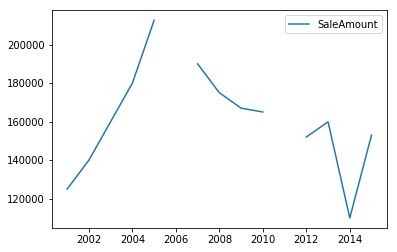

In [99]:
median_timeseries('Hartford', 'SaleAmount').plot()

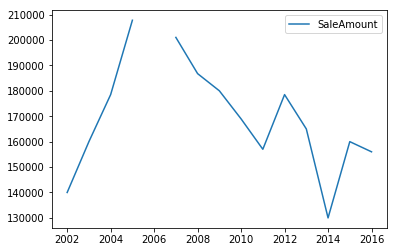

In [100]:
median_timeseries('Meriden', 'SaleAmount').plot()

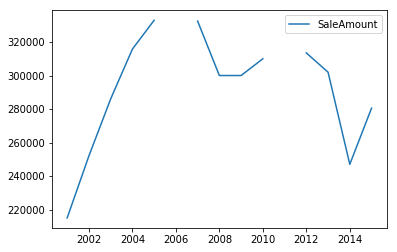

In [101]:
median_timeseries('Milford', 'SaleAmount').plot()

### Best way to break up towns to look at them?
* Metropolitan areas?
* Nonmetropolitan areas?
* Above statewide pre-recession median vs. below statewide pre-recession median vs. at statewide pre-recession median?

### Calculate and graph statewide median timeseries